In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install textgenrnn

In [0]:
!pip install keract

In [0]:
file = "/content/drive/My Drive/Christmas-Carol-Generator-master/lyrics/All I Want For Christmas Is You.txt"

## textgenrnn
https://github.com/minimaxir/textgenrnn

In [0]:
from textgenrnn import textgenrnn
textgen = textgenrnn()
textgen.train_from_file(file, num_epochs=100)

In [16]:
for _ in range(5):
  textgen.generate()

I just wanna keep on waiting

I don't want a lot for Christmas

There upon the fireplace

I don't want a lot for Christmas

All I want for Christmas is you, baby



## keras attention mechanism
https://github.com/philipperemy/keras-attention-mechanism

In [0]:
from tensorflow.keras.layers import Dense, Lambda, dot, Activation, concatenate


def attention_3d_block(hidden_states):
    # @author: felixhao28.
    # hidden_states.shape = (batch_size, time_steps, hidden_size)
    hidden_size = int(hidden_states.shape[2])
    # Inside dense layer
    #              hidden_states            dot               W            =>           score_first_part
    # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
    # W is the trainable weight matrix of attention Luong's multiplicative style score
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    #            score_first_part           dot        last_hidden_state     => attention_weights
    # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keract import get_activations
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

INPUT_DIM = 100
TIME_STEPS = 20

def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.randint(input_dim, size=(n, time_steps))
    x = np.eye(input_dim)[x]
    y = x[:, attention_column, :]
    return x, y


def get_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    rnn_out = LSTM(32, return_sequences=True)(inputs)
    attention_output = attention_3d_block(rnn_out)
    output = Dense(INPUT_DIM, activation='sigmoid', name='output')(attention_output)
    m = Model(inputs=[inputs], outputs=[output])
    print(m.summary())
    return m

In [12]:
n = 300000
inputs, outputs = get_data_recurrent(n, TIME_STEPS, INPUT_DIM)

m = get_model()
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
m.fit(x=[inputs], y=outputs, epochs=2, batch_size=64, validation_split=0)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 100)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 32)       17024       input_1[0][0]                    
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 20, 32)       1024        lstm[0][0]                       
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 32)           0           lstm[0][0]                       
______________________________________________________________________________________________

In [0]:
num_simulations = 10
attention_vectors = np.zeros(shape=(num_simulations, TIME_STEPS))
for i in range(num_simulations):
    testing_inputs_1, testing_outputs = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
    activations = get_activations(m, testing_inputs_1, layer_name='attention_weight')
    #activations = K.function([m.layers[0].input], [m.layers[1].output])
    attention_vec = np.mean(activations['attention_weight'], axis=0).squeeze()
    assert np.abs(np.sum(attention_vec) - 1.0) < 1e-5
    attention_vectors[i] = attention_vec

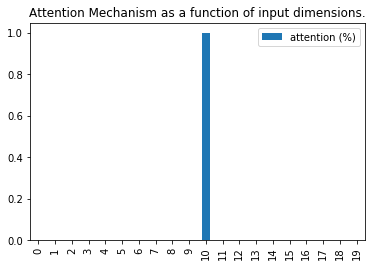

In [16]:
attention_vector_final = np.mean(attention_vectors, axis=0)
attention_df = pd.DataFrame(attention_vector_final, columns=['attention (%)'])
attention_df.plot(kind='bar', title='Attention Mechanism as a function of input dimensions.')
plt.show()